In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# ===== LOAD  DATASET =====
df = pd.read_csv('important_features.csv')
print(f"Loaded dataset: {df.shape}")

# ===== DATA PREPROCESSING =====
def preprocess_for_ml(df):
    """Complete preprocessing for machine learning"""
    
    # Remove ID columns and get features/target
    X = df.drop(['HADM_ID', 'SUBJECT_ID', 'READMIT_30'], axis=1, errors='ignore')
    y = df['READMIT_30']
    
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    
    # Identify data types
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Numerical columns: {len(numerical_cols)}")
    
    # Handle categorical variables
    X_processed = X.copy()
    
    for col in categorical_cols:
        if col in X_processed.columns:
            try:
                # Convert to string first, then label encode
                le = LabelEncoder()
                X_processed[col] = le.fit_transform(X_processed[col].astype(str))
                print(f" Encoded {col}")
            except Exception as e:
                print(f"Failed to encode {col}: {e}")
                # Drop problematic columns
                X_processed = X_processed.drop(columns=[col])
                print(f"Dropped {col}")
    

    
    # ensure all data is numeric
    X_processed = X_processed.select_dtypes(include=[np.number])
    
    print(f"Final processed features: {X_processed.shape}")
    return X_processed, y

# Preprocess the data
X, y = preprocess_for_ml(df)

# ===== TRAIN-TEST SPLIT =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain/Test Split:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Class distribution - Train: {y_train.value_counts().to_dict()}")
print(f"Class distribution - Test: {y_test.value_counts().to_dict()}")

# ===== MODEL TRAINING =====
models = {}
results = {}

# Random Forest
print(f"\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model

rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_pred = rf_model.predict(X_test)
rf_auc = roc_auc_score(y_test, rf_pred_proba)
rf_accuracy = (rf_pred == y_test).mean()

results['Random Forest'] = {
    'AUC': rf_auc,
    'Accuracy': rf_accuracy,
    'Predictions': rf_pred,
    'Probabilities': rf_pred_proba
}

print(f"Random Forest - AUC: {rf_auc:.3f}, Accuracy: {rf_accuracy:.3f}")

# XGBoost
print(f"\n Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred = xgb_model.predict(X_test)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
xgb_accuracy = (xgb_pred == y_test).mean()

results['XGBoost'] = {
    'AUC': xgb_auc,
    'Accuracy': xgb_accuracy,
    'Predictions': xgb_pred,
    'Probabilities': xgb_pred_proba
}

print(f"XGBoost - AUC: {xgb_auc:.3f}, Accuracy: {xgb_accuracy:.3f}")

# Logistic Regression (baseline)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

print(f"\n Training Logistic Regression...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = (lr_model, scaler)

lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_pred = lr_model.predict(X_test_scaled)
lr_auc = roc_auc_score(y_test, lr_pred_proba)
lr_accuracy = (lr_pred == y_test).mean()

results['Logistic Regression'] = {
    'AUC': lr_auc,
    'Accuracy': lr_accuracy,
    'Predictions': lr_pred,
    'Probabilities': lr_pred_proba
}

print(f" Logistic Regression - AUC: {lr_auc:.3f}, Accuracy: {lr_accuracy:.3f}")

# ===== MODEL EVALUATION =====
print(f"\n MODEL PERFORMANCE SUMMARY")
print("=" * 50)

for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  • AUC-ROC: {metrics['AUC']:.3f}")
    print(f"  • Accuracy: {metrics['Accuracy']:.3f}")
    
    # Classification report 
    if metrics['AUC'] == max([r['AUC'] for r in results.values()]):
        print(f"\n BEST MODEL: {model_name}")
        print(f"Classification Report:")
        print(classification_report(y_test, metrics['Predictions'], 
                                  target_names=['No Readmission', '30-Day Readmission']))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, metrics['Predictions'])
        print(f"\nConfusion Matrix:")
        print(f"                Predicted")
        print(f"Actual    No    Yes")
        print(f"No      {cm[0,0]:4d}  {cm[0,1]:4d}")
        print(f"Yes     {cm[1,0]:4d}  {cm[1,1]:4d}")



Loaded dataset: (85226, 26)
Features shape: (85226, 24)
Target shape: (85226,)
Categorical columns (0): []
Numerical columns: 24
Final processed features: (85226, 24)

Train/Test Split:
X_train: (59658, 24)
X_test: (25568, 24)
Class distribution - Train: {0: 29829, 1: 29829}
Class distribution - Test: {1: 12784, 0: 12784}

Training Random Forest...
Random Forest - AUC: 0.988, Accuracy: 0.947

 Training XGBoost...
XGBoost - AUC: 0.991, Accuracy: 0.970

 Training Logistic Regression...
 Logistic Regression - AUC: 0.884, Accuracy: 0.790

 MODEL PERFORMANCE SUMMARY
Random Forest:
  • AUC-ROC: 0.988
  • Accuracy: 0.947
XGBoost:
  • AUC-ROC: 0.991
  • Accuracy: 0.970

 BEST MODEL: XGBoost
Classification Report:
                    precision    recall  f1-score   support

    No Readmission       0.96      0.98      0.97     12784
30-Day Readmission       0.98      0.96      0.97     12784

          accuracy                           0.97     25568
         macro avg       0.97      0.97    

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# --------------------- Random Forest ---------------------
rf_param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=20,           # Number of random combinations to try
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,           # Use all CPU cores
    random_state=42
)
grid_rf.fit(X_train, y_train)
print("Random Forest Best params:", grid_rf.best_params_)
print("Random Forest Best AUC:", grid_rf.best_score_)

# --------------------- XGBoost ---------------------
xgb_param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_xgb = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    param_distributions=xgb_param_dist,
    n_iter=30,           # Number of random combinations
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=42
)
grid_xgb.fit(X_train, y_train)
print("XGBoost Best params:", grid_xgb.best_params_)
print("XGBoost Best AUC:", grid_xgb.best_score_)

# --------------------- Logistic Regression ---------------------
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

lr_param_dist = {
    'lr__C': [0.01, 0.1, 1, 10]
}

grid_lr = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=lr_param_dist,
    n_iter=4,            
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=42
)
grid_lr.fit(X_train, y_train)
print("Logistic Regression Best params:", grid_lr.best_params_)
print("Logistic Regression Best AUC:", grid_lr.best_score_)


Random Forest Best params: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 8}
Random Forest Best AUC: 0.9866556698603609
XGBoost Best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
XGBoost Best AUC: 0.9914801690700387
Logistic Regression Best params: {'lr__C': 10}
Logistic Regression Best AUC: 0.8816622005480182


Check train vs test performance

Train >> Test → Model is overfitting.

Train ≈ Test → Model generalizes well.

Both low → Model is underfitting.

In [12]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

# Training performance
xgb_train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]
xgb_train_pred = xgb_model.predict(X_train)
train_auc = roc_auc_score(y_train, xgb_train_pred_proba)
train_acc = accuracy_score(y_train, xgb_train_pred)

# Test performance
xgb_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_test_pred = xgb_model.predict(X_test)
test_auc = roc_auc_score(y_test, xgb_test_pred_proba)
test_acc = accuracy_score(y_test, xgb_test_pred)

print(f"Train AUC: {train_auc:.3f}, Test AUC: {test_auc:.3f}")
print(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")


Train AUC: 0.994, Test AUC: 0.991
Train Accuracy: 0.974, Test Accuracy: 0.970


CHECK  WHETHER MODEL IS OVERFITTING

If CV AUC ≈ Test AUC, your model is likely not overfitting.

In [13]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print("5-Fold CV AUC scores:", cv_scores)
print("Mean CV AUC:", cv_scores.mean())


5-Fold CV AUC scores: [0.99062441 0.99243564 0.99138185 0.99094584 0.99234726]
Mean CV AUC: 0.9915470003652134


MODEL CALIBRATION CURVE

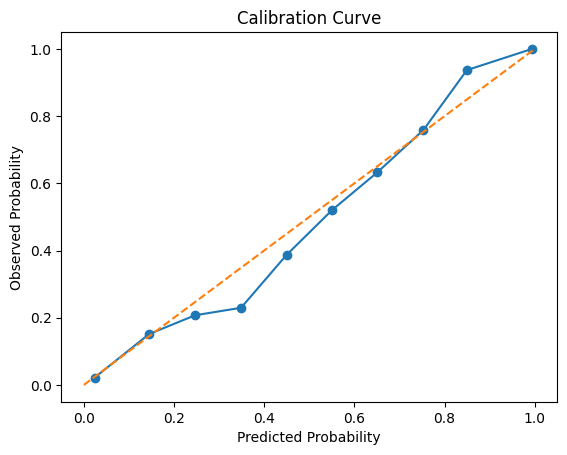

In [14]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, xgb_test_pred_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')  # perfect calibration
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration Curve")
plt.show()


Learning curves

Curves converge high → Well-fitted

Gap between curves → Overfitting

Both low → Underfitting

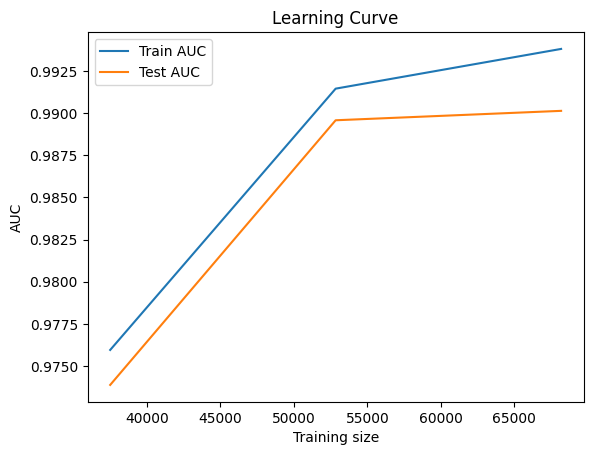

In [15]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X, y, cv=5, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Train AUC")
plt.plot(train_sizes, test_mean, label="Test AUC")
plt.xlabel("Training size")
plt.ylabel("AUC")
plt.legend()
plt.title("Learning Curve")
plt.show()


SAVE THE MODEL FILE 

In [ ]:
import joblib

# Save XGBoost
joblib.dump(models['XGBoost'], 'xgboost_model.joblib')
print("XGBoost model saved as xgboost_model.joblib")


Random Forest model saved as random_forest_model.joblib
XGBoost model saved as xgboost_model.joblib
Logistic Regression model and scaler saved as logistic_regression_model.joblib


In [5]:
import joblib

# After model training and predictions
results = {
    'XGBoost': {
        'Model': xgb_model,
        'Predictions': xgb_pred,
        'Probabilities': xgb_pred_proba
    }
}
joblib.dump(results, "model_results.pkl")
joblib.dump(y_test, "y_test.pkl")


['y_test.pkl']

MODEL COMPARISON

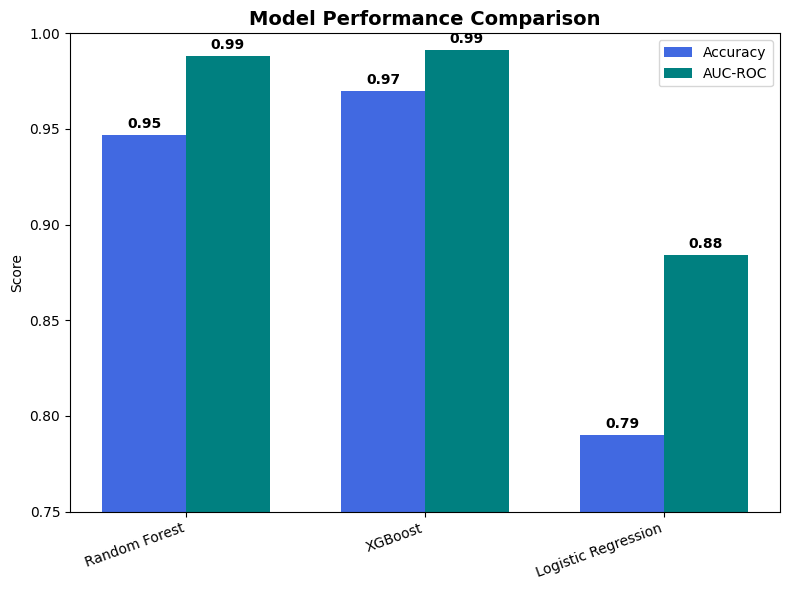

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract performance metrics
model_names = list(results.keys())
accuracy_scores = [results[m]['Accuracy'] for m in model_names]
auc_scores = [results[m]['AUC'] for m in model_names]

x = np.arange(len(model_names))  # model positions
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8, 6))

# Plot Accuracy and AUC
bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='royalblue')
bars2 = ax.bar(x + width/2, auc_scores, width, label='AUC-ROC', color='teal')

# Add values above bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customize plot
ax.set_title("Model Performance Comparison", fontsize=14, fontweight='bold')
ax.set_ylabel("Score")
ax.set_ylim([0.75, 1.0])
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=20, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


CONFUSION MATRIX VISUALIZATION



 CONFUSION MATRIX HEATMAP FOR BEST MODEL


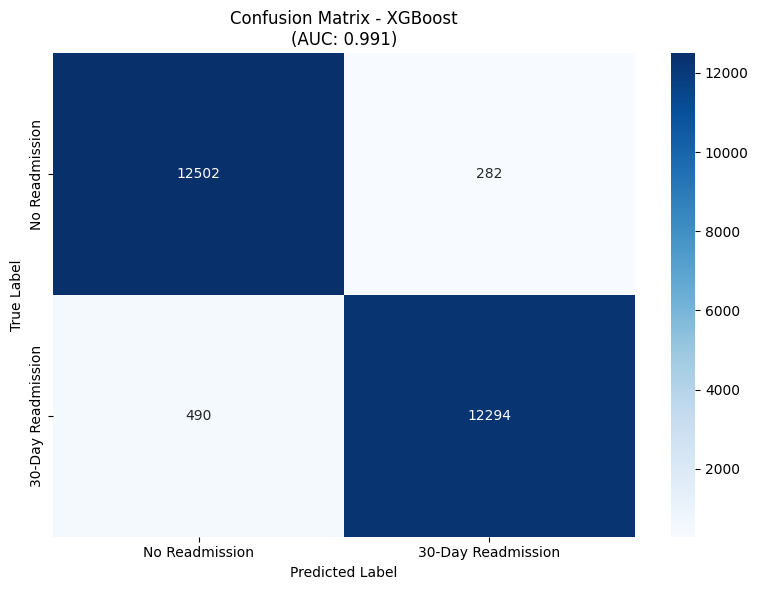


Confusion Matrix Values:
                Predicted
Actual    No    Yes
No      12502   282
Yes      490  12294


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ===== STEP 6: CONFUSION MATRIX HEATMAP =====
print(f"\n CONFUSION MATRIX HEATMAP FOR BEST MODEL")
print("=" * 45)

# Find the best model
best_auc = max([r['AUC'] for r in results.values()])
best_model_name = [name for name, r in results.items() if r['AUC'] == best_auc][0]
best_predictions = results[best_model_name]['Predictions']

# Calculate confusion matrix
cm = confusion_matrix(y_test, best_predictions)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Readmission', '30-Day Readmission'],
            yticklabels=['No Readmission', '30-Day Readmission'])
plt.title(f'Confusion Matrix - {best_model_name}\n(AUC: {best_auc:.3f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print numerical values for reference
print(f"\nConfusion Matrix Values:")
print(f"                Predicted")
print(f"Actual    No    Yes")
print(f"No      {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"Yes     {cm[1,0]:4d}  {cm[1,1]:4d}")

ROC CURVE FOR EACH MODEL

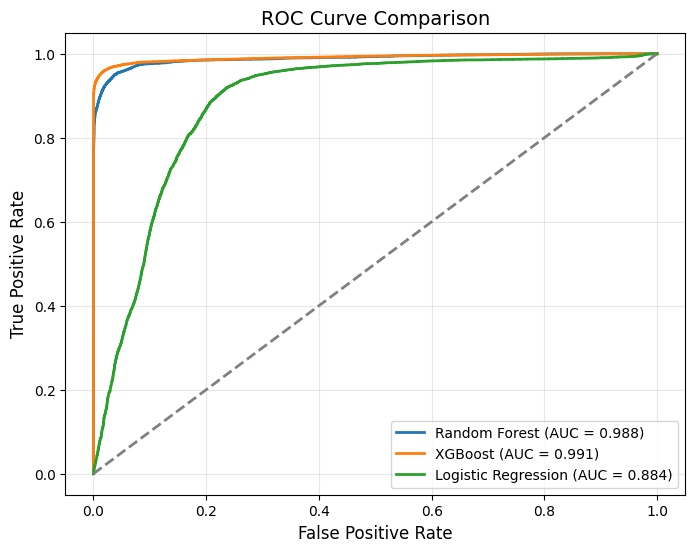

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ===== VISUALIZE ROC CURVES =====
plt.figure(figsize=(8, 6))

for model_name, metrics in results.items():
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, metrics['Probabilities'])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.3f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Formatting
plt.title("ROC Curve Comparison", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
